In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [2]:
from sklearn.metrics import mean_absolute_error

# Load the Data

In [3]:
# Load the data and inspect them
data = pd.read_csv('TSLA.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,7/10/2015,52.444000,52.599998,51.563999,51.830002,51.830002,13054500
1,7/13/2015,52.450001,52.509998,51.209999,52.431999,52.431999,14801500
2,7/14/2015,52.419998,53.198002,52.102001,53.130001,53.130001,9538000
3,7/15/2015,53.348000,53.498001,52.416000,52.627998,52.627998,10108000
4,7/16/2015,52.844002,53.439999,52.632000,53.335999,53.335999,8080000


Successfully Read!
<br>Date: the date of each record
<br>Open: first traded price on each trading day
<br>High: highest price on each trading day
<br>Low: lowest price on each trading day
<br>Close: last price on each trading day
<br>Adj close: adjusted close price
<br>Volume: the number of stocks traded on each trading day

What should we do next?
We need to learn the regulations of the data to do prediction. Based on observation and business knowledge, we could find that if we would like to do prediction, we could predict the closing prices. Then, the time series conditions of the closing price will be shown in the plot below.

<Axes: xlabel='Date'>

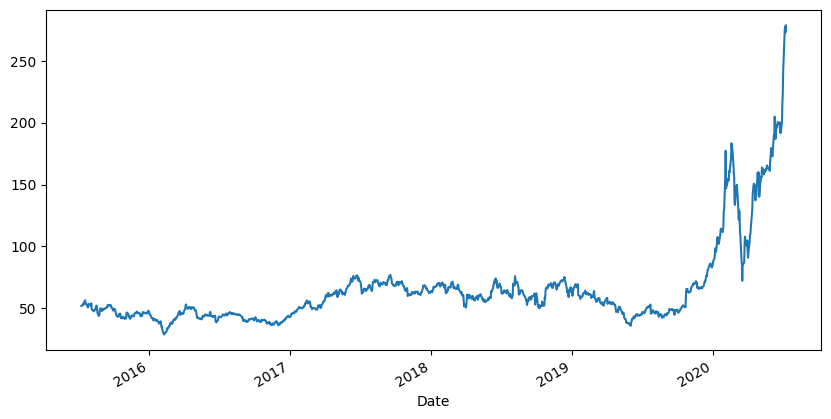

In [4]:
#visualization the stock price without lag
data= data[['Date', 'Close']]
data.Date = pd.to_datetime(data.Date, format = '%m/%d/%Y')

plot = data.set_index('Date')
plot['Close'].plot(figsize=(10,5))

# Split the data

In [5]:
#test data starts from 04/01/2020 to 07/09/2020
test_size = (data['Date'] >= '2020-04-01') & (data['Date'] <= '2020-07-09')
count = data.loc[test_size].shape[0]

print(count)

69


In [6]:
#choose the training set as the updated requirement, one year and 3 months
#the historical data is 3 months (before 04/01/2020)
train_size = (data['Date'] >= '2019-01-01') & (data['Date'] <= '2020-03-31')
count2 = data.loc[train_size].shape[0]

print(count2)

314


In [7]:
#we will continue working with the closing price(delete the date)
data_drop=data.drop(["Date"],axis=1)
data_new=data_drop.values

In [8]:
#normalized the data
scaler = MinMaxScaler(feature_range = (0, 1))
data_normalized = scaler.fit_transform(data_new)

In [9]:
#define training and test sets
training_set = data_normalized[-(69+314):-69,:]
test_set = data_normalized[-69:,:]

training_set.shape , test_set.shape

((314, 1), (69, 1))

#One-day time lag

In [10]:
def input_features(data, lag):
    X, Y = [], []
    for i in range(len(data) -lag):
        X.append(data[i:(i+1), 0])
        Y.append(data[i + lag, 0])
    return np.array(X), np.array(Y)

In [11]:
lag=1

In [12]:
X_train, Y_train = input_features(training_set, lag)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

In [13]:
X_train.shape

(313, 1, 1)

In [14]:
Y_train.shape

(313,)

In [15]:
def lstm(lstm_layer=6):
  model = Sequential()

  model.add(LSTM(units = 50, activation = 'relu', return_sequences=True,
                 input_shape = (X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.2))

  for layer in range(lstm_layer-1):
    model.add(LSTM(50, return_sequences= False))
    model.add(Dropout(0.2))

    model.add(Dense(1))

    return model

model1=lstm(lstm_layer=6)
model2=lstm(lstm_layer=6)

In [16]:
#change another drop rate
def lstm2(lstm_layer=6):
  model = Sequential()

  model.add(LSTM(units = 50, activation = 'relu', return_sequences=True,
                 input_shape = (X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.3))

  for layer in range(lstm_layer-1):
    model.add(LSTM(50, return_sequences= False))
    model.add(Dropout(0.3))

    model.add(Dense(1))

    return model

model3=lstm2(lstm_layer=6)
model4=lstm2(lstm_layer=4)

In [17]:
models={'drop_0.2_4_h_layer': model1, 'drop_0.2_6_h_layer': model2,
        'drop_0.3_4_h_layer': model3,'drop_0.3_6_h_layer': model4}

In [18]:
model1.compile(optimizer = 'adam', loss = 'mse' , metrics="mean_absolute_error")
model1.fit(X_train, Y_train, epochs = 100,batch_size = 20, verbose = 1, shuffle = False)

X_test_initial = training_set[-1:].reshape(1, 1,1)
first_prediction = model1.predict(X_test_initial)

  # Assuming X_test_initial and first_prediction are already defined and shaped correctly
X_test = [X_test_initial.flatten()]  # Start with the initial test set value
Y_test = [first_prediction.flatten()]  # Start with the initial prediction

for i in range(1, len(test_set)):
    # Reshape the last prediction to fit the model's expected input format
  current_input = np.array([Y_test[-1]]).reshape(1, 1, 1)
  current_prediction = model1.predict(current_input).flatten()

  X_test.append(current_input)
  Y_test.append(current_prediction)

Y_test = np.array(Y_test).reshape(-1, )
X_test = np.array(X_test).reshape(-1, 1, 1)

  # Inverse transform the predicted and actual values
Y_test_predicted1 = scaler.inverse_transform(np.array(Y_test).reshape(-1, 1))
actual_test_data = scaler.inverse_transform(test_set)

Epoch 1/100
16/16 [==============================] - 4s 5ms/step - loss: 0.0317 - mean_absolute_error: 0.1335
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0202 - mean_absolute_error: 0.0869
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0153 - mean_absolute_error: 0.0784
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0144 - mean_absolute_error: 0.0843
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0146 - mean_absolute_error: 0.0912
Epoch 6/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0147 - mean_absolute_error: 0.0924
Epoch 7/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0145 - mean_absolute_error: 0.0909
Epoch 8/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0133 - mean_absolute_error: 0.0873
Epoch 9/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0126 - mean_absolute_error: 0.0854
Epoch 10/1

<ipython-input-18-fd2181c0f53d>:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test = np.array(X_test).reshape(-1, 1, 1)


In [19]:
  # Calculate MAE on the test data
test_mae1 = mean_absolute_error(actual_test_data, Y_test_predicted1)

In [20]:
model2.compile(optimizer = 'adam', loss = 'mse' , metrics="mean_absolute_error")
model2.fit(X_train, Y_train, epochs = 100,batch_size = 20, verbose = 1, shuffle = False)

X_test_initial = training_set[-1:].reshape(1, 1,1)
first_prediction = model2.predict(X_test_initial)

  # Assuming X_test_initial and first_prediction are already defined and shaped correctly
X_test = [X_test_initial.flatten()]  # Start with the initial test set value
Y_test = [first_prediction.flatten()]  # Start with the initial prediction

for i in range(1, len(test_set)):
    # Reshape the last prediction to fit the model's expected input format
  current_input = np.array([Y_test[-1]]).reshape(1, 1, 1)
  current_prediction = model2.predict(current_input).flatten()

  X_test.append(current_input)
  Y_test.append(current_prediction)

Y_test = np.array(Y_test).reshape(-1, )
X_test = np.array(X_test).reshape(-1, 1, 1)

  # Inverse transform the predicted and actual values
Y_test_predicted2 = scaler.inverse_transform(np.array(Y_test).reshape(-1, 1))
actual_test_data = scaler.inverse_transform(test_set)

Epoch 1/100
16/16 [==============================] - 12s 13ms/step - loss: 0.0320 - mean_absolute_error: 0.1343
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0208 - mean_absolute_error: 0.0880
Epoch 3/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0160 - mean_absolute_error: 0.0794
Epoch 4/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0146 - mean_absolute_error: 0.0834
Epoch 5/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0152 - mean_absolute_error: 0.0909
Epoch 6/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0147 - mean_absolute_error: 0.0922
Epoch 7/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0146 - mean_absolute_error: 0.0908
Epoch 8/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0141 - mean_absolute_error: 0.0898
Epoch 9/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0135 - mean_absolute_error: 0.0882


<ipython-input-20-319e9e2ac114>:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test = np.array(X_test).reshape(-1, 1, 1)


In [21]:
  # Calculate MAE on the test data
test_mae2 = mean_absolute_error(actual_test_data, Y_test_predicted2)

In [22]:
model3.compile(optimizer = 'adam', loss = 'mse' , metrics="mean_absolute_error")
model3.fit(X_train, Y_train, epochs = 100,batch_size = 20, verbose = 1, shuffle = False)

X_test_initial = training_set[-1:].reshape(1, 1,1)
first_prediction = model3.predict(X_test_initial)

  # Assuming X_test_initial and first_prediction are already defined and shaped correctly
X_test = [X_test_initial.flatten()]  # Start with the initial test set value
Y_test = [first_prediction.flatten()]  # Start with the initial prediction

for i in range(1, len(test_set)):
    # Reshape the last prediction to fit the model's expected input format
  current_input = np.array([Y_test[-1]]).reshape(1, 1, 1)
  current_prediction = model3.predict(current_input).flatten()

  X_test.append(current_input)
  Y_test.append(current_prediction)

Y_test = np.array(Y_test).reshape(-1, )
X_test = np.array(X_test).reshape(-1, 1, 1)

  # Inverse transform the predicted and actual values
Y_test_predicted3 = scaler.inverse_transform(np.array(Y_test).reshape(-1, 1))
actual_test_data = scaler.inverse_transform(test_set)

Epoch 1/100
16/16 [==============================] - 5s 8ms/step - loss: 0.0321 - mean_absolute_error: 0.1346
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0212 - mean_absolute_error: 0.0895
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0164 - mean_absolute_error: 0.0797
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0152 - mean_absolute_error: 0.0846
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0151 - mean_absolute_error: 0.0898
Epoch 6/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0151 - mean_absolute_error: 0.0918
Epoch 7/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0148 - mean_absolute_error: 0.0916
Epoch 8/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0147 - mean_absolute_error: 0.0899
Epoch 9/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0141 - mean_absolute_error: 0.0890
Epoch 10/1

<ipython-input-22-9772beaaa93c>:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test = np.array(X_test).reshape(-1, 1, 1)


In [23]:
  # Calculate MAE on the test data
test_mae3 = mean_absolute_error(actual_test_data, Y_test_predicted3)

In [24]:
model4.compile(optimizer = 'adam', loss = 'mse' , metrics="mean_absolute_error")
model4.fit(X_train, Y_train, epochs = 100,batch_size = 20, verbose = 1, shuffle = False)

X_test_initial = training_set[-1:].reshape(1, 1,1)
first_prediction = model4.predict(X_test_initial)

  # Assuming X_test_initial and first_prediction are already defined and shaped correctly
X_test = [X_test_initial.flatten()]  # Start with the initial test set value
Y_test = [first_prediction.flatten()]  # Start with the initial prediction

for i in range(1, len(test_set)):
    # Reshape the last prediction to fit the model's expected input format
  current_input = np.array([Y_test[-1]]).reshape(1, 1, 1)
  current_prediction = model4.predict(current_input).flatten()

  X_test.append(current_input)
  Y_test.append(current_prediction)

Y_test = np.array(Y_test).reshape(-1, )
X_test = np.array(X_test).reshape(-1, 1, 1)

  # Inverse transform the predicted and actual values
Y_test_predicted4 = scaler.inverse_transform(np.array(Y_test).reshape(-1, 1))
actual_test_data = scaler.inverse_transform(test_set)

Epoch 1/100
16/16 [==============================] - 4s 5ms/step - loss: 0.0313 - mean_absolute_error: 0.1333
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0204 - mean_absolute_error: 0.0878
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0151 - mean_absolute_error: 0.0768
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0139 - mean_absolute_error: 0.0826
Epoch 5/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0135 - mean_absolute_error: 0.0873
Epoch 6/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0135 - mean_absolute_error: 0.0888
Epoch 7/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0132 - mean_absolute_error: 0.0877
Epoch 8/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0126 - mean_absolute_error: 0.0847
Epoch 9/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0123 - mean_absolute_error: 0.0841
Epoch 10/1

<ipython-input-24-a8cc228b3145>:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test = np.array(X_test).reshape(-1, 1, 1)


In [25]:
  # Calculate MAE on the test data
test_mae4 = mean_absolute_error(actual_test_data, Y_test_predicted4)

In [26]:
print('in the model 1, the test MAE is', test_mae1)
print('in the model 2, the test MAE is', test_mae2)
print('in the model 3, the test MAE is', test_mae3)
print('in the model 4, the test MAE is', test_mae4)

in the model 1, the test MAE is 89.37331106495557
in the model 2, the test MAE is 97.66939680961984
in the model 3, the test MAE is 104.21035317145748
in the model 4, the test MAE is 104.44902097458814


In [29]:
test_df = data.iloc[-69: , :]
test_df.Date = pd.to_datetime(test_df.Date, format = '%m/%d/%Y')

<ipython-input-29-54bd2da75b09>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.Date = pd.to_datetime(test_df.Date, format = '%m/%d/%Y')


In [30]:
test_df['Prediction1']=Y_test_predicted1
test_df['Prediction2']=Y_test_predicted2
test_df['Prediction3']=Y_test_predicted3
test_df['Prediction4']=Y_test_predicted4

<ipython-input-30-900d99806f53>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Prediction1']=Y_test_predicted1
<ipython-input-30-900d99806f53>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Prediction2']=Y_test_predicted2
<ipython-input-30-900d99806f53>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [31]:
test_df.head()

,Date,Close,Prediction1,Prediction2,Prediction3,Prediction4
1190,2020-04-01,96.311996,104.205917,102.610725,101.219688,102.384125
1191,2020-04-02,90.893997,103.598717,100.480400,97.805130,100.005272
1192,2020-04-03,96.001999,102.978775,98.415222,94.570374,97.671867
1193,2020-04-06,103.248001,102.346436,96.420517,91.525566,95.391762
1194,2020-04-07,109.089996,101.702126,94.500755,88.676918,93.172096


In [32]:
train_df = data.iloc[-(69+314):-69,:]
train_df.Date = pd.to_datetime(train_df.Date, format = '%Y/%m/%d')

<ipython-input-32-4307ad368346>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.Date = pd.to_datetime(train_df.Date, format = '%Y/%m/%d')


In [33]:
train_df.head()

,Date,Close
876,2019-01-02,62.023998
877,2019-01-03,60.071999
878,2019-01-04,63.537998
879,2019-01-07,66.991997
880,2019-01-08,67.070000


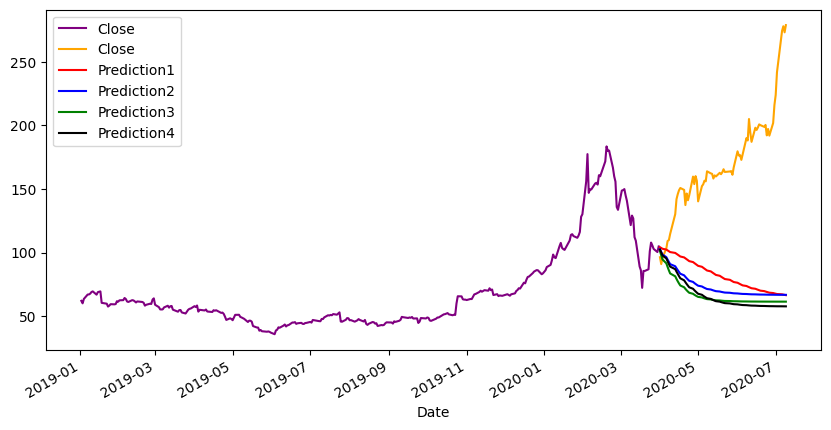

In [34]:
plot = train_df.set_index('Date')
plot2 = test_df.set_index('Date')

plot['Close'].plot(figsize=(10,5),color='purple')
plot2['Close'].plot(figsize=(10,5), color="orange")
plot2['Prediction1'].plot(figsize=(10,5),color="red")
plot2['Prediction2'].plot(figsize=(10,5),color="blue")
plot2['Prediction3'].plot(figsize=(10,5),color="green")
plot2['Prediction4'].plot(figsize=(10,5),color="black")

plt.legend()

#7-day time lag

In [35]:
def input_features(data, lag):
    X, Y = [], []
    for i in range(len(data) -lag):
        X.append(data[i:(i+1), 0])
        Y.append(data[i + lag, 0])
    return np.array(X), np.array(Y)

In [36]:
lag=7

In [37]:
training_set = data_normalized[-(69+308):-69,:]

In [38]:
X_train, Y_train = input_features(training_set, lag)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

In [39]:
X_train.shape

(301, 1, 1)

In [40]:
Y_train.shape

(301,)

In [41]:
flattened_data = X_train.flatten()

# Reshape to (n, 7, 1), with n being computed automatically
reshaped_data = flattened_data.reshape(-1, 7, 1)

# reshaped_data now has the shape (n, 7, 1), with the last element potentially having fewer than 7 entries
print(reshaped_data.shape)

(43, 7, 1)


In [42]:
num_rows = Y_train.shape[0] // 7  # This will be floor division

# Reshape the array to have 'num_rows' rows and 7 columns, discarding the excess elements
reshaped_array = Y_train[:num_rows * 7].reshape(num_rows, 7)

print(reshaped_array.shape)

(43, 7)


In [43]:
def lstm(lstm_layers=6, input_shape=(7, 1)):
    model = Sequential()

    # Adjust input_shape to have 7 timesteps
    model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))

    for layer in range(lstm_layers - 1):
        model.add(LSTM(50, return_sequences= True))
        model.add(Dropout(0.2))

    # Final Dense layer to output a single value
    model.add(Dense(1))

    return model

model1 = lstm(lstm_layers=6, input_shape=(7, 1))  # Now using 7 timesteps
model1.compile(optimizer='adam', loss='mse', metrics=["mean_absolute_error"])
model1.fit(reshaped_data, reshaped_array, epochs=100, batch_size=20, verbose=1, shuffle=False)

Epoch 1/100
3/3 [==============================] - 13s 24ms/step - loss: 0.0401 - mean_absolute_error: 0.1540
Epoch 2/100
3/3 [==============================] - 0s 24ms/step - loss: 0.0323 - mean_absolute_error: 0.1264
Epoch 3/100
3/3 [==============================] - 0s 24ms/step - loss: 0.0253 - mean_absolute_error: 0.1014
Epoch 4/100
3/3 [==============================] - 0s 24ms/step - loss: 0.0213 - mean_absolute_error: 0.0963
Epoch 5/100
3/3 [==============================] - 0s 24ms/step - loss: 0.0225 - mean_absolute_error: 0.1111
Epoch 6/100
3/3 [==============================] - 0s 26ms/step - loss: 0.0268 - mean_absolute_error: 0.1271
Epoch 7/100
3/3 [==============================] - 0s 26ms/step - loss: 0.0275 - mean_absolute_error: 0.1307
Epoch 8/100
3/3 [==============================] - 0s 28ms/step - loss: 0.0238 - mean_absolute_error: 0.1192
Epoch 9/100
3/3 [==============================] - 0s 29ms/step - loss: 0.0223 - mean_absolute_error: 0.1133
Epoch 10/100
3/3 [

In [44]:
X_test_initial = training_set[-8:-1,:].reshape(1, lag,1)

In [45]:
X_test_initial.shape

(1, 7, 1)

In [46]:
first_prediction = model1.predict(np.array(X_test_initial).reshape(-1,7))

1/1 [==============================] - 2s 2s/step


In [47]:
print(first_prediction)

[[[0.1738618 ]
  [0.21715873]
  [0.23509473]
  [0.25848785]
  [0.28659618]
  [0.30465072]
  [0.30489877]]]


In [48]:
first_prediction = [first_prediction.flatten()]

In [49]:
Y_test = [first_prediction[-1]]

for i in range(1, 9): #discard the last 69-9*7 nodes

    last_values = Y_test[-1]

    current_input = last_values.reshape(1, 7, 1)

    current_prediction = model1.predict(np.array(current_input).reshape(-1,7))

    Y_test.append(current_prediction[-1])


1/1 [==============================] - 0s 37ms/step


In [50]:
print(Y_test)

[array([0.1738618 , 0.21715873, 0.23509473, 0.25848785, 0.28659618,
       0.30465072, 0.30489877], dtype=float32), array([[0.16957483],
       [0.2033429 ],
       [0.20831774],
       [0.2209811 ],
       [0.24852216],
       [0.27752173],
       [0.29370427]], dtype=float32), array([[0.16922867],
       [0.20116076],
       [0.20128332],
       [0.20617078],
       [0.22660805],
       [0.2535148 ],
       [0.27356142]], dtype=float32), array([[0.16920072],
       [0.20089516],
       [0.20005932],
       [0.2026268 ],
       [0.21949443],
       [0.24299403],
       [0.26136917]], dtype=float32), array([[0.16919847],
       [0.20086624],
       [0.19988556],
       [0.20198792],
       [0.21788207],
       [0.24003686],
       [0.25710368]], dtype=float32), array([[0.16919827],
       [0.20086329],
       [0.19986364],
       [0.2018908 ],
       [0.21759094],
       [0.23941164],
       [0.25604716]], dtype=float32), array([[0.16919826],
       [0.20086297],
       [0.19986108],
 

In [51]:
flattened_data = np.concatenate([arr.flatten() for arr in Y_test])

# Reshape the concatenated array to have one column
reshaped_data = flattened_data.reshape(-1, 1)

len(reshaped_data)

63

In [52]:
# Inverse transform the predicted and actual values
Y_test_predicted1 = scaler.inverse_transform(np.array(reshaped_data).reshape(-1, 1))
actual_test_data = scaler.inverse_transform(test_set[:63,:])

  # Calculate MAE on the test data
test_mae1 = mean_absolute_error(actual_test_data, Y_test_predicted1)

In [53]:
print(test_mae1)

78.54699912403117


In [54]:
test_df = data.iloc[-69: -6, :]
test_df.Date = pd.to_datetime(test_df.Date, format = '%m/%d/%Y')

<ipython-input-54-32d0b79d96a4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.Date = pd.to_datetime(test_df.Date, format = '%m/%d/%Y')


In [55]:
test_df.shape

(63, 2)

In [56]:
test_df['Prediction1']=Y_test_predicted1
#test_df['Prediction2']=Y_test_predicted2
#test_df['Prediction3']=Y_test_predicted3
#test_df['Prediction4']=Y_test_predicted4

<ipython-input-56-fc813faaccff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Prediction1']=Y_test_predicted1


In [57]:
test_df.head()

,Date,Close,Prediction1
1190,2020-04-01,96.311996,72.220657
1191,2020-04-02,90.893997,83.050171
1192,2020-04-03,96.001999,87.536362
1193,2020-04-06,103.248001,93.387497
1194,2020-04-07,109.089996,100.418007


In [58]:
train_df = data.iloc[-(69+314):-69,:]
train_df.Date = pd.to_datetime(train_df.Date, format = '%Y/%m/%d')

<ipython-input-58-4307ad368346>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.Date = pd.to_datetime(train_df.Date, format = '%Y/%m/%d')


In [59]:
train_df.head()

,Date,Close
876,2019-01-02,62.023998
877,2019-01-03,60.071999
878,2019-01-04,63.537998
879,2019-01-07,66.991997
880,2019-01-08,67.070000


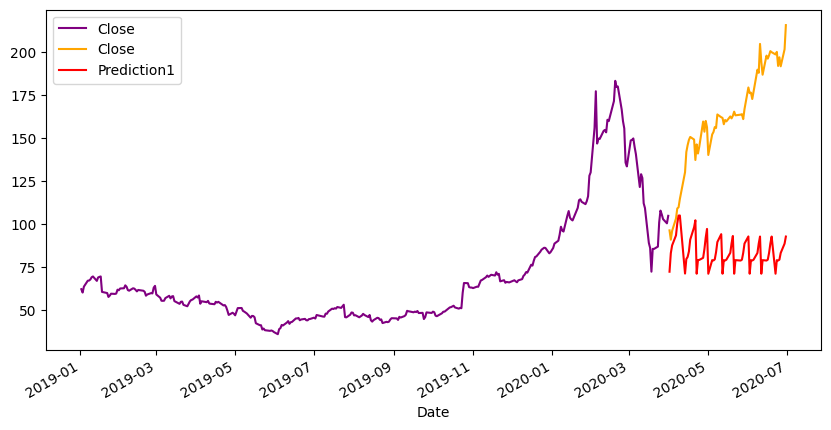

In [60]:
plot = train_df.set_index('Date')
plot3 = test_df.set_index('Date')

plot['Close'].plot(figsize=(10,5),color='purple')
plot3['Close'].plot(figsize=(10,5), color="orange")
plot3['Prediction1'].plot(figsize=(10,5),color="red")
#plot2['Prediction2'].plot(figsize=(10,5),color="blue")
#plot2['Prediction3'].plot(figsize=(10,5),color="green")
#plot2['Prediction4'].plot(figsize=(10,5),color="black")

plt.legend()

#14-day time lag

In [61]:
def input_features(data, lag):
    X, Y = [], []
    for i in range(len(data) -lag):
        X.append(data[i:(i+1), 0])
        Y.append(data[i + lag, 0])
    return np.array(X), np.array(Y)

In [62]:
lag=14

In [63]:
training_set = data_normalized[-(69+308):-69,:] #314/14=22..6 22*14=308

In [64]:
X_train, Y_train = input_features(training_set, lag)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

In [65]:
X_train.shape

(294, 1, 1)

In [66]:
Y_train.shape

(294,)

In [67]:
flattened_data = X_train.flatten()


reshaped_data = flattened_data.reshape(-1, 14, 1)


print(reshaped_data.shape)

(21, 14, 1)


In [68]:
num_rows = Y_train.shape[0] // 14  # This will be floor division

# Reshape the array to have 'num_rows' rows and 7 columns, discarding the excess elements
reshaped_array = Y_train[:num_rows * 14].reshape(num_rows, 14)

print(reshaped_array.shape)

(21, 14)


In [69]:
def lstm(lstm_layers=6, input_shape=(14, 1)):
    model = Sequential()

    # Adjust input_shape to have 7 timesteps
    model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))

    for layer in range(lstm_layers - 1):
        model.add(LSTM(50, return_sequences= True))
        model.add(Dropout(0.2))

    # Final Dense layer to output a single value
    model.add(Dense(1))

    return model

model1 = lstm(lstm_layers=6, input_shape=(14, 1))  # Now using 7 timesteps
model1.compile(optimizer='adam', loss='mse', metrics=["mean_absolute_error"])
model1.fit(reshaped_data, reshaped_array, epochs=100, batch_size=20, verbose=1, shuffle=False)

Epoch 1/100
2/2 [==============================] - 16s 80ms/step - loss: 0.0427 - mean_absolute_error: 0.1593
Epoch 2/100
2/2 [==============================] - 0s 62ms/step - loss: 0.0337 - mean_absolute_error: 0.1287
Epoch 3/100
2/2 [==============================] - 0s 58ms/step - loss: 0.0260 - mean_absolute_error: 0.1013
Epoch 4/100
2/2 [==============================] - 0s 52ms/step - loss: 0.0215 - mean_absolute_error: 0.1005
Epoch 5/100
2/2 [==============================] - 0s 59ms/step - loss: 0.0267 - mean_absolute_error: 0.1270
Epoch 6/100
2/2 [==============================] - 0s 58ms/step - loss: 0.0292 - mean_absolute_error: 0.1346
Epoch 7/100
2/2 [==============================] - 0s 59ms/step - loss: 0.0255 - mean_absolute_error: 0.1267
Epoch 8/100
2/2 [==============================] - 0s 60ms/step - loss: 0.0229 - mean_absolute_error: 0.1173
Epoch 9/100
2/2 [==============================] - 0s 59ms/step - loss: 0.0207 - mean_absolute_error: 0.1093
Epoch 10/100
2/2 [

In [70]:
X_test_initial = training_set[-15:-1,:].reshape(1, lag,1)

In [71]:
X_test_initial.shape

(1, 14, 1)

In [72]:
first_prediction = model1.predict(np.array(X_test_initial).reshape(-1,14))

1/1 [==============================] - 3s 3s/step


In [73]:
print(first_prediction)

[[[0.14737485]
  [0.19076857]
  [0.20513219]
  [0.2048727 ]
  [0.20105913]
  [0.20033611]
  [0.20531471]
  [0.2156449 ]
  [0.22929433]
  [0.2438072 ]
  [0.25715813]
  [0.26805872]
  [0.2758966 ]
  [0.2805337 ]]]


In [74]:
first_prediction = [first_prediction.flatten()]

In [75]:
Y_test = [first_prediction[-1]]

for i in range(1,4 ): #discard the last 69-4*14 nodes

    last_values = Y_test[-1]

    current_input = last_values.reshape(1, 14, 1)

    current_prediction = model1.predict(np.array(current_input).reshape(-1,14))

    Y_test.append(current_prediction[-1])


1/1 [==============================] - 0s 27ms/step


In [76]:
print(Y_test)

[array([0.14737485, 0.19076857, 0.20513219, 0.2048727 , 0.20105913,
       0.20033611, 0.20531471, 0.2156449 , 0.22929433, 0.2438072 ,
       0.25715813, 0.26805872, 0.2758966 , 0.2805337 ], dtype=float32), array([[0.1467099 ],
       [0.18752913],
       [0.19613653],
       [0.18644875],
       [0.17028862],
       [0.15637653],
       [0.15008906],
       [0.15369232],
       [0.16689575],
       [0.18760765],
       [0.21276164],
       [0.23907866],
       [0.26365444],
       [0.28431508]], dtype=float32), array([[0.14670806],
       [0.18751177],
       [0.19604862],
       [0.18613426],
       [0.1694028 ],
       [0.15429671],
       [0.14587584],
       [0.14615837],
       [0.15481387],
       [0.17003651],
       [0.18940938],
       [0.21059175],
       [0.23172833],
       [0.2515717 ]], dtype=float32), array([[0.14670806],
       [0.18751171],
       [0.19604808],
       [0.18613146],
       [0.16939162],
       [0.15426011],
       [0.14577393],
       [0.14591028],
   

In [77]:
flattened_data = np.concatenate([arr.flatten() for arr in Y_test])

# Reshape the concatenated array to have one column
reshaped_data = flattened_data.reshape(-1, 1)

len(reshaped_data)

56

In [78]:
# Inverse transform the predicted and actual values
Y_test_predicted1 = scaler.inverse_transform(np.array(reshaped_data).reshape(-1, 1))
actual_test_data = scaler.inverse_transform(test_set[:56,:])

  # Calculate MAE on the test data
test_mae1 = mean_absolute_error(actual_test_data, Y_test_predicted1)

In [79]:
print(test_mae1)

80.23761517659214


In [80]:
test_df = data.iloc[-69: -13, :]
test_df.Date = pd.to_datetime(test_df.Date, format = '%m/%d/%Y')

<ipython-input-80-184471c8b8c4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.Date = pd.to_datetime(test_df.Date, format = '%m/%d/%Y')


In [81]:
test_df.shape

(56, 2)

In [82]:
test_df['Prediction1']=Y_test_predicted1
#test_df['Prediction2']=Y_test_predicted2
#test_df['Prediction3']=Y_test_predicted3
#test_df['Prediction4']=Y_test_predicted4

<ipython-input-82-fc813faaccff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Prediction1']=Y_test_predicted1


In [83]:
test_df.head()

,Date,Close,Prediction1
1190,2020-04-01,96.311996,65.595695
1191,2020-04-02,90.893997,76.449409
1192,2020-04-03,96.001999,80.042068
1193,2020-04-06,103.248001,79.977165
1194,2020-04-07,109.089996,79.023308


In [84]:
train_df = data.iloc[-(69+314):-69,:]
train_df.Date = pd.to_datetime(train_df.Date, format = '%Y/%m/%d')

<ipython-input-84-4307ad368346>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.Date = pd.to_datetime(train_df.Date, format = '%Y/%m/%d')


In [85]:
train_df.head()

,Date,Close
876,2019-01-02,62.023998
877,2019-01-03,60.071999
878,2019-01-04,63.537998
879,2019-01-07,66.991997
880,2019-01-08,67.070000


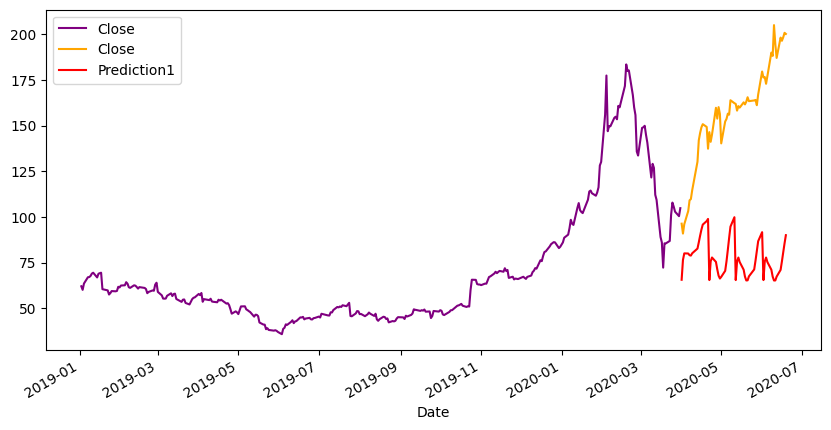

In [86]:
plot = train_df.set_index('Date')
plot4 = test_df.set_index('Date')

plot['Close'].plot(figsize=(10,5),color='purple')
plot4['Close'].plot(figsize=(10,5), color="orange")
plot4['Prediction1'].plot(figsize=(10,5),color="red")
#plot2['Prediction2'].plot(figsize=(10,5),color="blue")
#plot2['Prediction3'].plot(figsize=(10,5),color="green")
#plot2['Prediction4'].plot(figsize=(10,5),color="black")

plt.legend()

<Axes: xlabel='Date'>

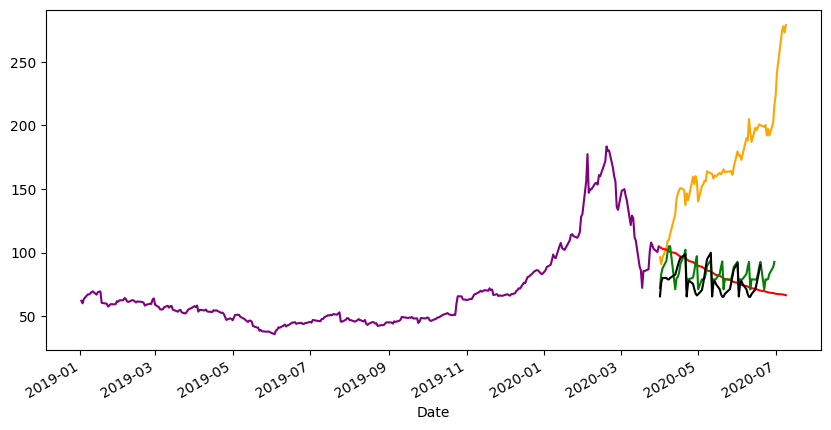

In [88]:
plot['Close'].plot(figsize=(10,5),color='purple')
plot2['Close'].plot(figsize=(10,5), color="orange")

plot2['Prediction1'].plot(figsize=(10,5),color="red")
plot3['Prediction1'].plot(figsize=(10,5), color="green")
plot4['Prediction1'].plot(figsize=(10,5),color="black")
